For a full explanation of the code, visit http://ataspinar.com/2017/08/15/building-convolutional-neural-networks-with-tensorflow/

In [1]:
import sys
sys.path.insert(0,'..')

from cnn_models.lenet5 import *
from cnn_models.lenet5_like import *
from cnn_models.alexnet import *
from cnn_models.vggnet16 import *
from utils import *

# To load the MNIST dataset you will need to install 'python-mnist'
# Install it with 'pip install python-mnist'
import load_data as ld

from collections import defaultdict
current_path = os.path.realpath('..')


# 1. Load on of the Three datasets

In [8]:
#1. The MNIST dataset: http://yann.lecun.com/exdb/mnist/
mnist_folder = os.path.join(current_path, 'datasets/mnist/')
mnist_image_width, mnist_image_height, mnist_image_depth, mnist_num_labels = 28, 28, 1, 10
train_dataset, train_labels, test_dataset, test_labels = ld.mnist(mnist_folder, mnist_image_width, mnist_image_height, mnist_image_depth)

# #2. The Cifar-10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html
# c10_folder = os.path.join(current_path, 'datasets/cifar10/')
# c10_image_width, c10_image_height, c10_image_depth, c10_num_labels = 32, 32, 3, 10
# train_dataset, train_labels, test_dataset, test_labels = ld.cifar10(c10_folder, c10_image_width, c10_image_height, c10_image_depth)


# #3. The oxflower-17 dataset: http://www.robots.ox.ac.uk/~vgg/data/flowers/17/
# ox16_folder = os.path.join(current_path, 'datasets/oxflower17/')
# ox17_image_width, ox17_image_height, ox17_image_depth, ox17_num_labels = 224, 224, 3, 17
# import tflearn.datasets.oxflower17 as oxflower17
# train_dataset_, train_labels_ = oxflower17.load_data(one_hot=True)
# train_dataset, train_labels = train_dataset_[:1000,:,:,:], train_labels_[:1000,:]
# test_dataset, test_labels = train_dataset_[1000:,:,:,:], train_labels_[1000:,:]

Loading MNIST dataset...
The MNIST training dataset contains 60000 images, each of size (28, 28, 1)
The MNIST test dataset contains 10000 images, each of size (28, 28, 1)
There are 10 number of labels.


In [9]:
#some meta-parameters
num_steps = 10001
#learning_rate = 0.1
learning_rates = [0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001]
display_step = 1000
batch_size = 64

#set the image dimensions
image_width, image_height, image_depth, num_labels = mnist_image_width, mnist_image_height, mnist_image_depth, mnist_num_labels
#image_width, image_height, image_depth, num_labels = c10_image_width, c10_image_height, c10_image_depth, c10_num_labels

#Define some variables in order to avoid the use of magic variables
MODEL_KEY = "adam_lenet5"
USED_DATASET= "CIFAR-10"

#save the accuracy at each step in these dictionaries
dict_train_accuracies = { MODEL_KEY: defaultdict(list) }
dict_test_accuracies = {  MODEL_KEY: defaultdict(list) }


for learning_rate in learning_rates:
    graph = tf.Graph()
    with graph.as_default():
        #1) First we put the input data in a tensorflow friendly form. 
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
        tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset, tf.float32)

        #2) 
        # Choose the 'variables' containing the weights and biases
        # You can choose from:
        # variables_lenet5() | variables_lenet5_like() | variables_alexnet() | variables_vggnet16()
        variables = variables_lenet5(image_width = image_width, image_height=image_height, image_depth = image_depth, num_labels = num_labels)

        #3.
        # Choose the model you will use to calculate the logits (predicted labels)
        # You can choose from:
        # model_lenet5       |  model_lenet5_like      | model_alexnet       | model_vggnet16
        model = model_lenet5
        logits = model(tf_train_dataset, variables)

        #4. 
        # Then we compute the softmax cross entropy between the logits and the (actual) labels
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

        #5. 
        # The optimizer is used to calculate the gradients of the loss function 
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        #optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.0).minimize(loss)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset, variables))


    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized with learning_rate', learning_rate)
        for step in range(num_steps):
            #Since we are using stochastic gradient descent, we are selecting  small batches from the training dataset,
            #and training the convolutional neural network each time with a batch. 
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            train_accuracy = accuracy(predictions, batch_labels)
            dict_train_accuracies[MODEL_KEY][learning_rate].append(train_accuracy)

            if step % display_step == 0:
                test_accuracy = accuracy(test_prediction.eval(), test_labels)
                dict_test_accuracies[MODEL_KEY][learning_rate].append(test_accuracy)
                message = "step {:04d} : loss is {:06.2f}, accuracy on training set {:02.2f} %, accuracy on test set {:02.2f} %".format(step, l, train_accuracy, test_accuracy)
                print(message)

Initialized with learning_rate 0.5
step 0000 : loss is 002.45, accuracy on training set 7.81 %, accuracy on test set 10.10 %
step 1000 : loss is 005.37, accuracy on training set 7.81 %, accuracy on test set 9.82 %
step 2000 : loss is 006.46, accuracy on training set 4.69 %, accuracy on test set 11.35 %
step 3000 : loss is 007.29, accuracy on training set 6.25 %, accuracy on test set 10.28 %
step 4000 : loss is 004.34, accuracy on training set 6.25 %, accuracy on test set 8.92 %
step 5000 : loss is 008.25, accuracy on training set 9.38 %, accuracy on test set 8.92 %
step 6000 : loss is 004.49, accuracy on training set 4.69 %, accuracy on test set 9.82 %
step 7000 : loss is 005.16, accuracy on training set 6.25 %, accuracy on test set 9.58 %
step 8000 : loss is 002.77, accuracy on training set 12.50 %, accuracy on test set 9.58 %
step 9000 : loss is 008.34, accuracy on training set 15.62 %, accuracy on test set 8.92 %
step 10000 : loss is 004.80, accuracy on training set 9.38 %, accuracy

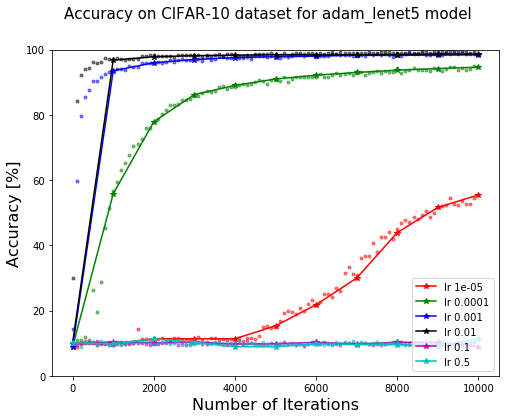

In [19]:
import matplotlib.pyplot as plt

def average_points(points, stepsize = 100):
    averaged_points = []
    for ii in range(stepsize,len(points),stepsize):
        subsection  = points[ii-stepsize:ii]
        average = np.nanmean(subsection)
        averaged_points.append(average)
    return averaged_points


models = list(dict_train_accuracies.keys())
colors = ['r', 'g', 'b', 'k', 'm', 'c']
ylimit = [0,100]


title = 'Accuracy on {} dataset for {} model'.format(USED_DATASET, MODEL_KEY)
ylabel = "Accuracy [%]"
xlabel = "Number of Iterations"

fig, ax1 = plt.subplots(figsize=(8,6))
fig.suptitle(title, fontsize=15)
ax1.set_ylim(ylimit)
ax1.set_ylabel(ylabel, fontsize=16)
ax1.set_xlabel(xlabel, fontsize=16)

learning_rates = sorted(list(dict_train_accuracies[MODEL_KEY].keys()))

for ii in range(len(learning_rates)):
    learning_rate = learning_rates[ii]
    color = colors[ii]
    y_values_train_ = dict_train_accuracies[MODEL_KEY][learning_rate]
    y_values_train = average_points(y_values_train_)
    x_values_train = range(0,len(y_values_train_)-1,100)

    y_values_test = dict_test_accuracies[MODEL_KEY][learning_rate]
    x_values_test = range(0,len(y_values_train_),1000)

    ax1.plot(x_values_train, y_values_train, '.{}'.format(color), alpha = 0.5)
    ax1.plot(x_values_test, y_values_test, '*-{}'.format(color), alpha = 1, label='lr {}'.format(learning_rate))
    ax1.legend(loc='lower right')
plt.show()

# ----------------------------------------
# These are the accuracies of the various models, on the three datasets that I got:


## LeNet5 Architecture

![LeNet5 Architecture](../figures/lenet5_architecture.png)

![title](../figures/mnist_test_score.png)
![title](../figures/cifar10_test_score.png)
![title](../figures/cifar10_test_score_optimizers.png)

![title](../figures/cifar10_test_accuracies_gd_optimizer.png)
![title](../figures/cifar10_test_accuracies_adag_optimizer.png)
![title](../figures/cifar10_test_accuracies_adam_optimizer.png)
![title](../figures/cifar10_test_accuracies_rms_optimizer.png)

## AlexNet Architecture

![AlexNet Architecture](../figures/alexnet_architecture.png)

![title](../figures/alexnet_test_score_different_optimizers.png)
